### TO DO - 
- Load the audio files
- Break into 5 second long clips
- Calculate below features for each clip
    - MFCC
    - Zero Crossing rate (librosa.feature.zero crossing_rate)
    - Short-time Fourier transform (STFT) + chromagram (librosa.stft +librosa.feature.chroma_stft)
    - root-mean-square (RMS) (librosa.feature.rms)
    - Me1-sca1ed spectrogram (librosa.feature.melspectrogram)
    - Me1-frequency cepstral coefficients (MFCCs)(1ibrosa.feature.mfcc)
    - Fast Fourier transform(FFT) (tf.signal.fft)
    - **Perceptual Linear Prediction (PLP)**
    - **Mel-frequency cepstral coefficients (MFCCs)**
    - **Power Normalized cepstral coefficents**
    - **Log Mel Filterbank energies**
    - **Fast Fourier transform(FFT)(tf.signa1.fft)**
    - **Zero Crossing rate (librosa.feature.zero_crossing_rate)**
- Append to a df having these columns
    - Name of user
    - Audio file name
    - All above features values

In [3]:
# load packages
import librosa
import os
import pandas as pd
import numpy 

In [5]:
import numpy as np

# Function to apply Bark scale
def apply_bark_scale(power_spectrum):
    # Perform Bark scale transformation on the power spectrum
    # You need to implement the specific Bark scale transformation
    # For simplicity, let's use a linear transformation as a placeholder
    bark_scale_spectrum = np.sqrt(power_spectrum)
    return bark_scale_spectrum

# Function for critical-band analysis


def apply_critical_band_analysis(bark_scale_spectrum):
    """
    Apply critical-band analysis to the Bark scale spectrum.

    Parameters:
    - bark_scale_spectrum: numpy array, the input Bark scale spectrum.

    Returns:
    - critical_band_result: numpy array, the result after critical-band analysis.
    """
    omega_values = np.arange(-1.3, 2.6, 0.1)
    critical_band_result = np.zeros_like(bark_scale_spectrum)

    # Apply the critical-band curve to the Bark scale spectrum
    for i in range(len(omega_values) - 1):
        mask = (omega_values[i] <= bark_scale_spectrum) & (bark_scale_spectrum <= omega_values[i+1])
        if omega_values[i] < -0.5:
            critical_band_result[mask] = 10**(2.5 * (bark_scale_spectrum[mask] + 0.5))
        elif -0.5 < omega_values[i] < 0.5:
            critical_band_result[mask] = 1
        elif 0.5 <= omega_values[i] <= 2.5:
            critical_band_result[mask] = 10**(-1.0 * (bark_scale_spectrum[mask] - 0.5))

    return critical_band_result


# Function for equal-loudness preemphasis
def equal_loudness_preemphasis(bark_scale_spectrum):
    # Implement equal-loudness preemphasis
    # You might need to adjust the parameters according to your needs
    # For simplicity, let's use a linear transformation as a placeholder
    return bark_scale_spectrum

# Function for power-law intensity transformation
def power_law_intensity_transformation(bark_scale_spectrum):
    # Apply power-law transformation (y = x^(1/3))
    return bark_scale_spectrum**(1/3)


In [6]:
def rasta_plp_feature_extraction(signal, sr):
    # Perform RASTA-PLP feature extraction
    # Add the RASTA-PLP steps here
    
    # Set frame size to 20 ms
    frame_size_ms = 20
    frame_size_samples = int((frame_size_ms / 1000) * sr)

    # Set hop length to half of the frame size (50% overlap)
    hop_length = frame_size_samples // 2

    # Manually perform framing and windowing
    num_frames = 1 + (len(signal) - frame_size_samples) // hop_length
    frames = np.stack([signal[i * hop_length:i * hop_length + frame_size_samples] * np.hamming(frame_size_samples) for i in range(num_frames)])

    # Continue with the remaining RASTA-PLP steps
    power_spectrum = np.abs(np.fft.fft(frames, axis=0))**2
    bark_scale_spectrum = apply_bark_scale(power_spectrum)
    critical_band_result = apply_critical_band_analysis(bark_scale_spectrum)
    preemphasis_result = equal_loudness_preemphasis(critical_band_result)
    intensity_transformed = power_law_intensity_transformation(preemphasis_result)
    
    # For simplicity, let's use the mean as a summary statistic for each feature
    rasta_plp_features = np.mean(intensity_transformed, axis=1)
    
    return rasta_plp_features

In [7]:
# df for Arun

import librosa
import pandas as pd
# import pyrubberband

# Load the audio file
audio, sr = librosa.load("Complete Dataset/Individual Voices - Train/Arunanshu/arun.wav", sr=44100)

# Convert the sample rate to integer
sr = int(sr)

# Calculate the total number of clips
clip_duration = 5
clip_samples = int(sr * clip_duration)
total_clips = len(audio) // clip_samples

# Create the output DataFrame
columns = ["Names"] + [f"MFCC_{i+1}" for i in range(13)] + ["Chroma", "SpectralContrast", "Tonnetz", "ZeroCrossingRate", "RMSEnergy"] + [f"LogMelFilterbank_{i+1}" for i in range(30)]+ ["RASTA-PLP"]
dfArun = pd.DataFrame(columns=columns)
dfArun["Names"] = "Arunanshu"

# Split the audio into clips and extract features for each clip
for i in range(total_clips):
    clip_start = i * clip_samples
    clip_end = (i + 1) * clip_samples
    clip = audio[clip_start:clip_end]

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
    mfccs_flattened = mfccs.mean(axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=clip, sr=sr)

    # Extract Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=clip, sr=sr)

    # Extract Tonnetz features
    tonnetz = librosa.feature.tonnetz(y=clip, sr=sr)

    # Extract Zero Crossing Rate
    zero_crossings = librosa.feature.zero_crossing_rate(y=clip)

    # Extract RMS Energy
    rms_energy = librosa.feature.rms(y=clip)

    # Extract Log Mel Filterbank Energies with 30 mel filterbanks
    mel_filterbank_energies = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=30)
    log_mel_filterbank_energies = librosa.power_to_db(mel_filterbank_energies)

    # Extract the mean of Log Mel Filterbank Energies along the time axis
    log_mel_filterbank_energies_flattened = log_mel_filterbank_energies.mean(axis=1).tolist()
    
    rasta_plp_features = rasta_plp_feature_extraction(clip, sr)
   # print(np.mean(rasta_plp_features.tolist()))

    # Concatenate all features into a single row
    row_values = ["Arunanshu"] + mfccs_flattened.tolist() + [chroma.mean(), contrast.mean(), tonnetz.mean(), zero_crossings.mean(), rms_energy.mean()] + log_mel_filterbank_energies_flattened + [np.mean(rasta_plp_features.tolist())]


    
    # Append the row to the DataFrame
    dfArun = dfArun._append(pd.Series(row_values, index=dfArun.columns), ignore_index=True)


# Display the resulting DataFrame
dfArun

C:\Users\maddula.sai\AppData\Local\Temp\ipykernel_4732\4096642185.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfArun = dfArun._append(pd.Series(row_values, index=dfArun.columns), ignore_index=True)


,Names,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LogMelFilterbank_22,LogMelFilterbank_23,LogMelFilterbank_24,LogMelFilterbank_25,LogMelFilterbank_26,LogMelFilterbank_27,LogMelFilterbank_28,LogMelFilterbank_29,LogMelFilterbank_30,RASTA-PLP
0,Arunanshu,-398.515503,95.550636,5.952597,-5.154275,5.881031,-3.027374,-7.761910,-10.212845,-14.519335,...,-49.774456,-50.957180,-51.288067,-51.290344,-51.292488,-51.294460,-51.296204,-51.297623,-51.298595,0.642121
1,Arunanshu,-317.800323,171.617676,19.697014,-20.370554,-5.757511,-5.969464,-11.277127,-18.355204,-21.422365,...,-47.427387,-48.540958,-49.163948,-49.203705,-49.248993,-49.248413,-49.263485,-49.271469,-49.274387,0.496999
2,Arunanshu,-324.595490,157.516998,22.634710,-20.010984,-9.555398,-7.517561,-12.459773,-16.917850,-19.326172,...,-48.045940,-48.755985,-48.908695,-49.024067,-49.160210,-49.273827,-49.335701,-49.433483,-49.478497,0.499368
3,Arunanshu,-320.546265,156.666412,17.499743,-14.465985,1.115923,-3.048698,-9.033537,-14.968829,-23.260252,...,-47.934559,-49.155994,-49.536232,-49.582375,-49.664959,-49.695789,-49.687527,-49.702763,-49.704502,0.540353
4,Arunanshu,-359.157013,136.366379,15.336736,-6.177477,-1.002159,-11.322202,-10.241114,-8.933396,-14.962830,...,-47.878162,-49.499832,-50.128464,-50.226109,-50.330399,-50.397057,-50.485462,-50.518032,-50.578228,0.540744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Arunanshu,-272.985016,156.234863,8.562659,2.233527,4.421247,-19.408325,-18.868141,-14.964703,-22.607065,...,-40.596123,-43.097736,-44.364445,-44.854176,-45.246609,-45.621647,-45.889854,-46.126328,-46.298748,0.347254
298,Arunanshu,-301.409332,151.073273,13.328385,-3.532950,3.682272,-13.942816,-21.172998,-17.158211,-18.870380,...,-43.066986,-44.512169,-45.509216,-45.824993,-46.100613,-46.332726,-46.515644,-46.675728,-46.825127,0.375827
299,Arunanshu,-298.691864,138.497818,8.385637,1.111421,7.382024,-12.918744,-19.167109,-15.739915,-18.572334,...,-40.941368,-42.921108,-43.947773,-44.356487,-44.588596,-44.888569,-45.092319,-45.281555,-45.412979,0.365542
300,Arunanshu,-303.454163,131.693344,6.567013,4.198251,3.867085,-20.174046,-18.340120,-12.247305,-18.664288,...,-41.221466,-43.940735,-45.238876,-45.533203,-45.952168,-46.193668,-46.434689,-46.627968,-46.754116,0.379202


In [8]:
# df for Dhanush

import librosa
import pandas as pd
# import pyrubberband

# Load the audio file
audio, sr = librosa.load("Complete Dataset/Individual Voices - Train/Dhanush/Dhanush.wav", sr=44100)

# Convert the sample rate to integer
sr = int(sr)

# Calculate the total number of clips
clip_duration = 5
clip_samples = int(sr * clip_duration)
total_clips = len(audio) // clip_samples

# Create the output DataFrame
columns = ["Names"] + [f"MFCC_{i+1}" for i in range(13)] + ["Chroma", "SpectralContrast", "Tonnetz", "ZeroCrossingRate", "RMSEnergy"] + [f"LogMelFilterbank_{i+1}" for i in range(30)] +["RASTA-PLP"]
dfDhanush = pd.DataFrame(columns=columns)
dfDhanush["Names"] = "Dhanush"

# Split the audio into clips and extract features for each clip
for i in range(total_clips):
    clip_start = i * clip_samples
    clip_end = (i + 1) * clip_samples
    clip = audio[clip_start:clip_end]

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
    mfccs_flattened = mfccs.mean(axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=clip, sr=sr)

    # Extract Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=clip, sr=sr)

    # Extract Tonnetz features
    tonnetz = librosa.feature.tonnetz(y=clip, sr=sr)

    # Extract Zero Crossing Rate
    zero_crossings = librosa.feature.zero_crossing_rate(y=clip)

    # Extract RMS Energy
    rms_energy = librosa.feature.rms(y=clip)

    # Extract Log Mel Filterbank Energies with 30 mel filterbanks
    mel_filterbank_energies = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=30)
    log_mel_filterbank_energies = librosa.power_to_db(mel_filterbank_energies)

    # Extract the mean of Log Mel Filterbank Energies along the time axis
    log_mel_filterbank_energies_flattened = log_mel_filterbank_energies.mean(axis=1).tolist()
    rasta_plp_features = rasta_plp_feature_extraction(clip, sr)

    # Concatenate all features into a single row
    row_values = ["Dhanush"] + mfccs_flattened.tolist() + [chroma.mean(), contrast.mean(), tonnetz.mean(), zero_crossings.mean(), rms_energy.mean()] + log_mel_filterbank_energies_flattened+ [np.mean(rasta_plp_features.tolist())]

    # Append the row to the DataFrame
    dfDhanush = dfDhanush._append(pd.Series(row_values, index=dfDhanush.columns), ignore_index=True)


# Display the resulting DataFrame
dfDhanush

C:\Users\maddula.sai\AppData\Local\Temp\ipykernel_4732\467674640.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfDhanush = dfDhanush._append(pd.Series(row_values, index=dfDhanush.columns), ignore_index=True)


,Names,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LogMelFilterbank_22,LogMelFilterbank_23,LogMelFilterbank_24,LogMelFilterbank_25,LogMelFilterbank_26,LogMelFilterbank_27,LogMelFilterbank_28,LogMelFilterbank_29,LogMelFilterbank_30,RASTA-PLP
0,Dhanush,-446.782623,120.282440,8.975777,12.957669,18.859741,-8.761703,-4.898654,0.962463,-15.166978,...,-54.881050,-56.804691,-57.349064,-57.353645,-57.357929,-57.361877,-57.365364,-57.367195,-57.368160,0.776853
1,Dhanush,-434.466980,136.553726,31.851372,4.300361,2.335369,-7.704080,-1.745498,0.403396,-14.487670,...,-54.890682,-55.952370,-56.178162,-56.185188,-56.191856,-56.196262,-56.199745,-56.202595,-56.204544,0.750734
2,Dhanush,-453.514069,137.269516,13.729777,4.051022,9.522449,-8.709485,-0.718198,3.900674,-14.080851,...,-55.938080,-57.796017,-58.601761,-58.606846,-58.609150,-58.611198,-58.612968,-58.614552,-58.615524,0.813420
3,Dhanush,-435.983246,146.025909,20.246609,1.718480,14.302771,-2.806926,-4.760407,1.272426,-13.750760,...,-57.788628,-58.144310,-58.328804,-58.331024,-58.333199,-58.335232,-58.336971,-58.338413,-58.339428,0.744052
4,Dhanush,-442.020142,155.722794,11.448459,14.532580,23.761103,-8.633047,-4.544482,1.917174,-18.639271,...,-57.869705,-59.654625,-61.158302,-61.165043,-61.171299,-61.177177,-61.182503,-61.186863,-61.189774,0.784979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Dhanush,-391.903503,151.799896,0.615312,3.020825,16.636162,-12.572773,-8.270164,0.655857,-13.345028,...,-52.883320,-54.917511,-56.131092,-56.137886,-56.144344,-56.150272,-56.155499,-56.159721,-56.162621,0.704294
296,Dhanush,-419.513947,156.536911,15.879122,4.907450,11.102242,-12.867729,-7.363818,1.002937,-12.183702,...,-55.636719,-57.296158,-58.398708,-58.403347,-58.407627,-58.411598,-58.415119,-58.417931,-58.419998,0.766566
297,Dhanush,-392.118774,151.185593,-10.621017,0.137030,9.920803,-19.861242,-2.019152,5.940520,-17.007547,...,-51.794338,-54.992981,-56.778397,-56.780693,-56.782848,-56.784859,-56.786629,-56.788048,-56.789024,0.724621
298,Dhanush,-411.092285,126.917961,-15.229196,12.989119,24.160116,-14.840909,-5.492054,1.944793,-15.369877,...,-51.548481,-55.512169,-57.772549,-57.781757,-57.790379,-57.798397,-57.805340,-57.811024,-57.815002,0.738380


In [9]:
# df for Hari

import librosa
import pandas as pd
# import pyrubberband

# Load the audio file
audio, sr = librosa.load("Complete Dataset/Individual Voices - Train/Hari/HarikrishnanNair.wav", sr=44100)

# Convert the sample rate to integer
sr = int(sr)

# Calculate the total number of clips
clip_duration = 5
clip_samples = int(sr * clip_duration)
total_clips = len(audio) // clip_samples

# Create the output DataFrame
columns = ["Names"] + [f"MFCC_{i+1}" for i in range(13)] + ["Chroma", "SpectralContrast", "Tonnetz", "ZeroCrossingRate", "RMSEnergy"] + [f"LogMelFilterbank_{i+1}" for i in range(30)]+ ["RASTA-PLP"]
dfHari = pd.DataFrame(columns=columns)
dfHari["Names"] = "Hari"

# Split the audio into clips and extract features for each clip
for i in range(total_clips):
    clip_start = i * clip_samples
    clip_end = (i + 1) * clip_samples
    clip = audio[clip_start:clip_end]

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
    mfccs_flattened = mfccs.mean(axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=clip, sr=sr)

    # Extract Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=clip, sr=sr)

    # Extract Tonnetz features
    tonnetz = librosa.feature.tonnetz(y=clip, sr=sr)

    # Extract Zero Crossing Rate
    zero_crossings = librosa.feature.zero_crossing_rate(y=clip)

    # Extract RMS Energy
    rms_energy = librosa.feature.rms(y=clip)

    # Extract Log Mel Filterbank Energies with 30 mel filterbanks
    mel_filterbank_energies = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=30)
    log_mel_filterbank_energies = librosa.power_to_db(mel_filterbank_energies)

    # Extract the mean of Log Mel Filterbank Energies along the time axis
    log_mel_filterbank_energies_flattened = log_mel_filterbank_energies.mean(axis=1).tolist()
    rasta_plp_features = rasta_plp_feature_extraction(clip, sr)

    # Concatenate all features into a single row
    row_values = ["Hari"] + mfccs_flattened.tolist() + [chroma.mean(), contrast.mean(), tonnetz.mean(), zero_crossings.mean(), rms_energy.mean()] + log_mel_filterbank_energies_flattened+ [np.mean(rasta_plp_features.tolist())]

    # Append the row to the DataFrame
    dfHari = dfHari._append(pd.Series(row_values, index=dfHari.columns), ignore_index=True)


# Display the resulting DataFrame
dfHari

C:\Users\maddula.sai\AppData\Local\Temp\ipykernel_4732\2669682594.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfHari = dfHari._append(pd.Series(row_values, index=dfHari.columns), ignore_index=True)


,Names,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LogMelFilterbank_22,LogMelFilterbank_23,LogMelFilterbank_24,LogMelFilterbank_25,LogMelFilterbank_26,LogMelFilterbank_27,LogMelFilterbank_28,LogMelFilterbank_29,LogMelFilterbank_30,RASTA-PLP
0,Hari,-566.290894,111.426933,14.568611,27.961140,24.468811,16.751135,22.386120,6.362034,5.979140,...,-54.436440,-56.005135,-67.341995,-67.336166,-67.344551,-67.345467,-67.349907,-67.349014,-67.351051,0.990299
1,Hari,-504.964050,146.146973,-10.319264,25.640938,19.720272,9.026011,27.599709,5.702899,6.254302,...,-45.488766,-48.071999,-69.332077,-69.334061,-69.336182,-69.338272,-69.339981,-69.341309,-69.342224,0.994450
2,Hari,-527.003906,136.601639,0.187863,20.039314,21.219584,12.146822,18.989483,4.540471,7.989459,...,-50.209175,-52.893456,-68.508095,-68.510277,-68.512421,-68.514458,-68.515205,-68.517609,-68.518562,0.991286
3,Hari,-480.620544,157.711533,-5.892729,23.108604,15.236580,9.764928,22.072678,-1.475073,8.438230,...,-42.926605,-44.994965,-68.551582,-68.555977,-68.560104,-68.563950,-68.556297,-68.557732,-68.570175,0.977214
4,Hari,-473.369049,133.576492,-15.273721,23.789965,14.552983,13.401636,28.684437,-4.761396,1.423877,...,-41.558735,-42.701405,-64.903900,-64.910896,-64.910896,-64.910896,-64.910896,-64.910896,-64.910896,0.974971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,Hari,-351.756592,130.403015,-24.750034,21.689222,13.774352,2.706240,21.531559,-2.067163,-1.608013,...,-30.526413,-32.063564,-54.679569,-54.679569,-54.679569,-54.679569,-54.677864,-54.679569,-54.679569,0.789738
297,Hari,-397.685028,142.814713,-18.235453,15.975750,22.197773,8.979705,16.155785,3.119884,6.072245,...,-38.005569,-40.094955,-60.229061,-60.229061,-60.229061,-60.229061,-60.203960,-60.216686,-60.229061,0.845163
298,Hari,-378.359344,143.632767,-19.289621,15.039219,19.795919,6.111427,15.724963,0.344194,1.337459,...,-37.110561,-39.040340,-58.326115,-58.328346,-58.329514,-58.329514,-58.316360,-58.329514,-58.329514,0.814092
299,Hari,-412.539612,149.047333,-26.944937,23.963263,28.010008,7.902147,17.435495,-0.866316,3.531227,...,-39.000553,-41.127773,-62.137451,-62.141949,-62.145851,-62.147812,-62.120316,-62.150928,-62.151943,0.899287


In [10]:
# df for Pratham

import librosa
import pandas as pd
# import pyrubberband

# Load the audio file
audio, sr = librosa.load("Complete Dataset/Individual Voices - Train/Pratham/Pratham.wav", sr=44100)

# Convert the sample rate to integer
sr = int(sr)

# Calculate the total number of clips
clip_duration = 5
clip_samples = int(sr * clip_duration)
total_clips = len(audio) // clip_samples

# Create the output DataFrame
columns = ["Names"] + [f"MFCC_{i+1}" for i in range(13)] + ["Chroma", "SpectralContrast", "Tonnetz", "ZeroCrossingRate", "RMSEnergy"] + [f"LogMelFilterbank_{i+1}" for i in range(30)]+ ["RASTA-PLP"]
dfPratham = pd.DataFrame(columns=columns)
dfPratham["Names"] = "Pratham"

# Split the audio into clips and extract features for each clip
for i in range(total_clips):
    clip_start = i * clip_samples
    clip_end = (i + 1) * clip_samples
    clip = audio[clip_start:clip_end]

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
    mfccs_flattened = mfccs.mean(axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=clip, sr=sr)

    # Extract Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=clip, sr=sr)

    # Extract Tonnetz features
    tonnetz = librosa.feature.tonnetz(y=clip, sr=sr)

    # Extract Zero Crossing Rate
    zero_crossings = librosa.feature.zero_crossing_rate(y=clip)

    # Extract RMS Energy
    rms_energy = librosa.feature.rms(y=clip)

    # Extract Log Mel Filterbank Energies with 30 mel filterbanks
    mel_filterbank_energies = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=30)
    log_mel_filterbank_energies = librosa.power_to_db(mel_filterbank_energies)

    # Extract the mean of Log Mel Filterbank Energies along the time axis
    log_mel_filterbank_energies_flattened = log_mel_filterbank_energies.mean(axis=1).tolist()
    rasta_plp_features = rasta_plp_feature_extraction(clip, sr)

    # Concatenate all features into a single row
    row_values = ["Pratham"] + mfccs_flattened.tolist() + [chroma.mean(), contrast.mean(), tonnetz.mean(), zero_crossings.mean(), rms_energy.mean()] + log_mel_filterbank_energies_flattened+ [np.mean(rasta_plp_features.tolist())]

    # Append the row to the DataFrame
    dfPratham = dfPratham._append(pd.Series(row_values, index=dfPratham.columns), ignore_index=True)


# Display the resulting DataFrame
dfPratham

C:\Users\maddula.sai\AppData\Local\Temp\ipykernel_4732\3241937197.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPratham = dfPratham._append(pd.Series(row_values, index=dfPratham.columns), ignore_index=True)


,Names,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LogMelFilterbank_22,LogMelFilterbank_23,LogMelFilterbank_24,LogMelFilterbank_25,LogMelFilterbank_26,LogMelFilterbank_27,LogMelFilterbank_28,LogMelFilterbank_29,LogMelFilterbank_30,RASTA-PLP
0,Pratham,-570.259583,87.005348,21.835659,37.278450,55.193680,31.828026,11.708835,-6.586849,-4.666298,...,-60.368240,-59.404922,-59.593887,-60.620983,-61.949635,-62.647308,-60.697342,-57.723637,-56.836571,0.998705
1,Pratham,-537.067749,128.917526,22.660654,14.928118,54.746223,28.676277,-2.387557,-8.621281,0.285822,...,-64.486290,-61.914948,-59.936077,-60.681671,-61.589954,-62.973232,-60.161442,-57.460976,-57.039055,0.997427
2,Pratham,-472.837952,147.430374,1.499998,14.439448,50.628262,18.224474,-4.653209,2.754280,-8.331213,...,-62.550629,-60.584377,-57.712776,-58.405579,-59.094070,-60.933399,-59.697979,-59.278904,-59.303127,0.953388
3,Pratham,-492.540009,163.068680,1.381232,14.890907,67.223351,23.869820,-4.854313,2.166888,-8.755168,...,-66.231636,-63.483780,-62.746765,-62.935894,-62.763672,-63.014034,-61.484734,-60.522591,-60.034893,0.983358
4,Pratham,-492.794098,120.538177,11.355522,29.110584,55.543312,29.376556,4.051781,-0.313020,-6.804705,...,-58.848618,-56.940571,-56.070557,-57.176846,-58.627838,-59.498699,-57.800446,-58.131351,-57.470200,0.979559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Pratham,-437.668182,140.687393,20.285200,5.345737,37.238930,7.116364,-15.066447,-0.308156,0.775279,...,-58.153004,-54.442097,-52.966938,-54.177467,-53.483814,-54.444508,-51.976086,-51.075298,-52.778458,0.936796
288,Pratham,-449.798920,83.161926,14.831575,15.308598,32.816296,13.900643,-1.714774,-0.983646,-4.377119,...,-51.619720,-49.312302,-47.790913,-49.173557,-49.138584,-51.341240,-48.446667,-47.292278,-48.953869,0.905650
289,Pratham,-478.835052,82.240067,17.422600,25.251034,41.910275,18.777891,-2.398127,-1.575871,0.771020,...,-54.021606,-52.317413,-50.059422,-52.731140,-52.850262,-54.234467,-52.153831,-51.468510,-51.733887,0.954063
290,Pratham,-468.360596,72.639534,19.577122,21.420576,37.741058,15.400746,-2.917547,3.897957,3.778859,...,-51.817699,-51.025829,-48.338863,-49.721741,-49.137714,-51.282089,-48.444160,-48.352722,-49.665852,0.942050


In [11]:
dfArun["RASTA-PLP"].describe()

count    302.000000
mean       0.390367
std        0.048535
min        0.310468
25%        0.362277
50%        0.379429
75%        0.404899
max        0.722025
Name: RASTA-PLP, dtype: float64

In [13]:
dfPratham["RASTA-PLP"].describe()

count    292.000000
mean       0.951458
std        0.021440
min        0.877801
25%        0.936370
50%        0.953440
75%        0.966307
max        0.998705
Name: RASTA-PLP, dtype: float64

In [12]:
df = pd.concat([dfArun, dfDhanush, dfHari, dfPratham], ignore_index=True)
df

,Names,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LogMelFilterbank_22,LogMelFilterbank_23,LogMelFilterbank_24,LogMelFilterbank_25,LogMelFilterbank_26,LogMelFilterbank_27,LogMelFilterbank_28,LogMelFilterbank_29,LogMelFilterbank_30,RASTA-PLP
0,Arunanshu,-398.515503,95.550636,5.952597,-5.154275,5.881031,-3.027374,-7.761910,-10.212845,-14.519335,...,-49.774456,-50.957180,-51.288067,-51.290344,-51.292488,-51.294460,-51.296204,-51.297623,-51.298595,0.642121
1,Arunanshu,-317.800323,171.617676,19.697014,-20.370554,-5.757511,-5.969464,-11.277127,-18.355204,-21.422365,...,-47.427387,-48.540958,-49.163948,-49.203705,-49.248993,-49.248413,-49.263485,-49.271469,-49.274387,0.496999
2,Arunanshu,-324.595490,157.516998,22.634710,-20.010984,-9.555398,-7.517561,-12.459773,-16.917850,-19.326172,...,-48.045940,-48.755985,-48.908695,-49.024067,-49.160210,-49.273827,-49.335701,-49.433483,-49.478497,0.499368
3,Arunanshu,-320.546265,156.666412,17.499743,-14.465985,1.115923,-3.048698,-9.033537,-14.968829,-23.260252,...,-47.934559,-49.155994,-49.536232,-49.582375,-49.664959,-49.695789,-49.687527,-49.702763,-49.704502,0.540353
4,Arunanshu,-359.157013,136.366379,15.336736,-6.177477,-1.002159,-11.322202,-10.241114,-8.933396,-14.962830,...,-47.878162,-49.499832,-50.128464,-50.226109,-50.330399,-50.397057,-50.485462,-50.518032,-50.578228,0.540744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,Pratham,-437.668182,140.687393,20.285200,5.345737,37.238930,7.116364,-15.066447,-0.308156,0.775279,...,-58.153004,-54.442097,-52.966938,-54.177467,-53.483814,-54.444508,-51.976086,-51.075298,-52.778458,0.936796
1191,Pratham,-449.798920,83.161926,14.831575,15.308598,32.816296,13.900643,-1.714774,-0.983646,-4.377119,...,-51.619720,-49.312302,-47.790913,-49.173557,-49.138584,-51.341240,-48.446667,-47.292278,-48.953869,0.905650
1192,Pratham,-478.835052,82.240067,17.422600,25.251034,41.910275,18.777891,-2.398127,-1.575871,0.771020,...,-54.021606,-52.317413,-50.059422,-52.731140,-52.850262,-54.234467,-52.153831,-51.468510,-51.733887,0.954063
1193,Pratham,-468.360596,72.639534,19.577122,21.420576,37.741058,15.400746,-2.917547,3.897957,3.778859,...,-51.817699,-51.025829,-48.338863,-49.721741,-49.137714,-51.282089,-48.444160,-48.352722,-49.665852,0.942050


In [14]:
# Import label encoder 
from sklearn import preprocessing 

# label_encoder object knows 
# how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in column 'species'. 
df['Names']= label_encoder.fit_transform(df['Names']) 

df['Names'].unique() 


array([0, 1, 2, 3])

In [15]:
X=df.iloc[:,1:]
y=df.iloc[:,0]

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler



# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to the DataFrame
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Display the normalized DataFrame
print("\nNormalized DataFrame:")
X



Normalized DataFrame:


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,LogMelFilterbank_22,LogMelFilterbank_23,LogMelFilterbank_24,LogMelFilterbank_25,LogMelFilterbank_26,LogMelFilterbank_27,LogMelFilterbank_28,LogMelFilterbank_29,LogMelFilterbank_30,RASTA-PLP
0,0.565193,0.390727,0.601127,0.262424,0.173097,0.383165,0.299512,0.315859,0.284809,0.459650,...,0.440482,0.400260,0.629626,0.686123,0.696854,0.708416,0.673641,0.683486,0.705033,0.481887
1,0.787526,0.875929,0.784361,0.013926,0.042588,0.334201,0.248257,0.060535,0.121490,0.349778,...,0.503302,0.476958,0.703745,0.765469,0.775774,0.788746,0.749530,0.760235,0.784126,0.271027
2,0.768808,0.785986,0.823525,0.019798,0.000000,0.308437,0.231012,0.105607,0.171084,0.341603,...,0.486747,0.470132,0.712652,0.772300,0.779203,0.787748,0.746834,0.754098,0.776151,0.274470
3,0.779962,0.780561,0.755068,0.110354,0.119663,0.382810,0.280971,0.166723,0.078008,0.229864,...,0.489728,0.457435,0.690755,0.751070,0.759710,0.771181,0.733699,0.743898,0.767320,0.334021
4,0.673607,0.651075,0.726232,0.245714,0.095912,0.245119,0.263363,0.355979,0.274316,0.368608,...,0.491237,0.446520,0.670089,0.726592,0.734010,0.743649,0.703909,0.713016,0.733180,0.334588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,0.457346,0.678637,0.792202,0.433900,0.524730,0.551981,0.193004,0.626445,0.646663,0.655393,...,0.216227,0.289638,0.571044,0.576339,0.612224,0.584742,0.648259,0.691907,0.647209,0.910047
1191,0.423932,0.311704,0.719497,0.596605,0.475137,0.664888,0.387686,0.605264,0.524763,0.687234,...,0.391093,0.452473,0.751656,0.766616,0.780038,0.706579,0.780025,0.835206,0.796650,0.864792
1192,0.343951,0.305824,0.754039,0.758975,0.577112,0.746057,0.377722,0.586693,0.646562,0.747613,...,0.326806,0.357082,0.672498,0.631336,0.636692,0.592989,0.641623,0.677012,0.688025,0.935136
1193,0.372803,0.244586,0.782762,0.696420,0.530361,0.689853,0.370148,0.758338,0.717724,0.850243,...,0.385794,0.398080,0.732535,0.745771,0.780072,0.708902,0.780119,0.795037,0.768830,0.917681


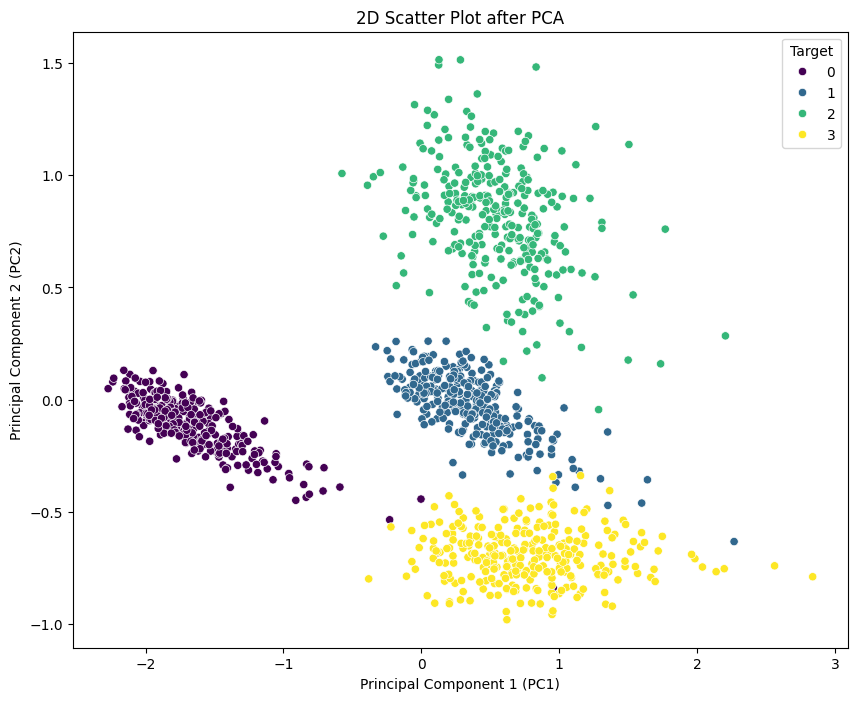

In [17]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for better aesthetics



# Perform PCA to reduce the dimensionality of X to 2 components
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Create a DataFrame with the reduced dimensions and target variable
result_df = pd.DataFrame(data=X_2d, columns=['PC1', 'PC2'])
result_df['Target'] = y

# Plot the 2D scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Target', data=result_df, palette='viridis', legend='full')
plt.title('2D Scatter Plot after PCA')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming X is your features DataFrame and y is your target variable DataFrame
# Make sure X and y are in the right format (numpy arrays or pandas DataFrames).

# Assuming X and y are in separate DataFrames
# If they are in the same DataFrame, you can skip the next two lines


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(result_df.iloc[:,:-1],
result_df["Target"], test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_model = LogisticRegression()#multi_class='multinomial', solver='lbfgs')
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more detailed metrics
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       0.94      1.00      0.97        64
           2       1.00      0.95      0.98        64
           3       1.00      0.98      0.99        50

    accuracy                           0.98       239
   macro avg       0.99      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239



In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y are your feature and target variable DataFrames
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(result_df.iloc[:,:-1],
result_df["Target"], test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)  # You can customize the kernel and other parameters

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Display more detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9832635983263598
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       0.94      1.00      0.97        64
           2       1.00      0.95      0.98        64
           3       1.00      0.98      0.99        50

    accuracy                           0.98       239
   macro avg       0.99      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239



In [ ]:
selected_features = ['Names', 'MFCC_6', 'MFCC_5', 'LogMelFilterbank_7', 'LogMelFilterbank_6',
                     'MFCC_4']

df_selected = df[selected_features]
df_selected

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Create a heatmap
sns.set(style="whitegrid")  # Optional: Set the seaborn style
plt.figure(figsize=(10, 8))  # Optional: Set the figure size

# Create the heatmap using seaborn's heatmap function
sns.heatmap(df.iloc[:, 1:], cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)

# Display the heatmap
plt.show()


In [ ]:
my_list = list(df)

print (my_list)

In [ ]:
import librosa
import pandas as pd
import numpy as np

# Load the audio file
audio, sr = librosa.load("Complete Dataset/Individual Voices - Train/Arunanshu/arun.wav", sr=44100)

# Calculate the total number of clips
clip_duration = 5
clip_samples = int(sr * clip_duration)
total_clips = len(audio) // clip_samples

# Create the output DataFrame
columns = ["Names"] + [f"PNCC_{i+1}" for i in range(13)]
dfTest = pd.DataFrame(columns=columns)
dfTest["Names"] = "Trial"

# Split the audio into clips and extract features for each clip
for i in range(total_clips):
    clip_start = i * clip_samples
    clip_end = (i + 1) * clip_samples
    clip = audio[clip_start:clip_end]

    # Extract MFCC features
    mfcc_features = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)

    # Normalize the cepstral coefficients (equivalent to PNCC)
    pncc_features = (mfcc_features - np.mean(mfcc_features, axis=1)[:, np.newaxis]) / (np.std(mfcc_features, axis=1)[:, np.newaxis] + 1e-8)

    # Concatenate all features into a single row
    row_values = ["Trial"] + pncc_features.mean(axis=1).tolist()

    # Append the row to the DataFrame
    dfTest = dfTest._append(pd.Series(row_values, index=dfTest.columns), ignore_index=True)

# Display the resulting DataFrame
dfTest

In [ ]:
from librosa.core import stft
from librosa import filters
from librosa import to_mono
import numpy as np

import scipy


def medium_time_power_calculation(power_stft_signal, M=2):
    medium_time_power = np.zeros_like(power_stft_signal)
    power_stft_signal = np.pad(power_stft_signal, [(M, M), (0, 0)], 'constant')
    for i in range(medium_time_power.shape[0]):
        medium_time_power[i, :] = sum([1 / float(2 * M + 1) *
                                       power_stft_signal[i + k - M, :]
                                       for k in range(2 * M + 1)])
    return medium_time_power


def asymmetric_lawpass_filtering(rectified_signal, lm_a=0.999, lm_b=0.5):
    floor_level = np.zeros_like(rectified_signal)
    floor_level[0, ] = 0.9 * rectified_signal[0, ]
    for m in range(floor_level.shape[0]):
        floor_level[m, ] = np.where(rectified_signal[m, ] >=
                                    floor_level[m - 1, ],
                                    lm_a * floor_level[m - 1, ] +
                                    (1 - lm_a) * rectified_signal[m, ],
                                    lm_b * floor_level[m - 1, ] +
                                    (1 - lm_b) * rectified_signal[m, ])

    return floor_level


def halfwave_rectification(subtracted_lower_envelope, th=0):
    return np.where(subtracted_lower_envelope < th,
                    np.zeros_like(subtracted_lower_envelope),
                    subtracted_lower_envelope)


def temporal_masking(rectified_signal, lam_t=0.85, myu_t=0.2):
        # rectified_signal[m, l]
    temporal_masked_signal = np.zeros_like(rectified_signal)
    online_peak_power = np.zeros_like(rectified_signal)
    temporal_masked_signal[0, :] = rectified_signal[0, ]
    online_peak_power[0, :] = rectified_signal[0, :]
    for m in range(1, rectified_signal.shape[0]):
        online_peak_power[m, :] = np.maximum(lam_t * online_peak_power[m-1, :],
                                             rectified_signal[m, :])
        temporal_masked_signal[m, :] = np.where(
            rectified_signal[m, :] >= lam_t * online_peak_power[m - 1, :],
            rectified_signal[m, :],
            myu_t * online_peak_power[m - 1, :])

    return temporal_masked_signal


def switch_excitation_or_non_excitation(temporal_masked_signal,
                                        floor_level, lower_envelope,
                                        medium_time_power, c=2):
    return np.where(medium_time_power >= c * lower_envelope,
                    temporal_masked_signal, floor_level)


def weight_smoothing(final_output, medium_time_power, N=4, L=128):

    spectral_weight_smoothing = np.zeros_like(final_output)
    for m in range(final_output.shape[0]):
        for l in range(final_output.shape[1]):
            l_1 = max(l - N, 1)
            l_2 = min(l + N, L)
            spectral_weight_smoothing[m, l] = (1/float(l_2 - l_1 + 1)) * \
            sum([(final_output[m, l_] / medium_time_power[m, l_])
                 for l_ in range(l_1, l_2)])
    return spectral_weight_smoothing


def time_frequency_normalization(power_stft_signal,
                                 spectral_weight_smoothing):
    return power_stft_signal * spectral_weight_smoothing


def mean_power_normalization(transfer_function,
                             final_output, lam_myu=0.999, L=80, k=1):
    myu = np.zeros(shape=(transfer_function.shape[0]))
    myu[0] = 0.0001
    normalized_power = np.zeros_like(transfer_function)
    for m in range(1, transfer_function.shape[0]):
        myu[m] = lam_myu * myu[m - 1] + \
            (1 - lam_myu) / L * \
            sum([transfer_function[m, s] for s in range(0, L - 1)])
    normalized_power = k * transfer_function / myu[:, None]

    return normalized_power


def power_function_nonlinearity(normalized_power, n=15):
    return normalized_power ** float(1 / n)


def pncc(audio_wave, n_fft=512, sr=16000, winlen=0.020, winstep=0.010,
         n_mels=128, n_pncc=13, weight_N=4, power=2):

    pre_emphasis_signal = scipy.signal.lfilter([1.0, -0.97], 1, audio_wave)
    mono_wave = to_mono(pre_emphasis_signal.T)
    stft_pre_emphasis_signal = np.abs(stft(mono_wave,
                                           n_fft=n_fft,
                                           hop_length=int(sr * winstep),
                                           win_length=int(sr * winlen),
                                           window=np.ones(int(sr * winlen)),
                                           center=False)) ** power

    mel_filter = np.abs(filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)) ** power
    power_stft_signal = np.dot(stft_pre_emphasis_signal.T, mel_filter.T)

    medium_time_power = medium_time_power_calculation(power_stft_signal)

    lower_envelope = asymmetric_lawpass_filtering(
        medium_time_power, 0.999, 0.5)

    subtracted_lower_envelope = medium_time_power - lower_envelope

    rectified_signal = halfwave_rectification(subtracted_lower_envelope)

    floor_level = asymmetric_lawpass_filtering(rectified_signal)

    temporal_masked_signal = temporal_masking(rectified_signal)

    final_output = switch_excitation_or_non_excitation(
        temporal_masked_signal, floor_level, lower_envelope,
        medium_time_power)

    spectral_weight_smoothing = weight_smoothing(
        final_output, medium_time_power, L=n_mels)

    transfer_function = time_frequency_normalization(
        power_stft_signal,
        spectral_weight_smoothing)

    normalized_power = mean_power_normalization(
        transfer_function, final_output, L=n_mels)

    power_law_nonlinearity = power_function_nonlinearity(normalized_power)

    dct = scipy.fftpack.dct(power_law_nonlinearity, axis=1, type=2, norm='ortho')[:, :n_pncc]

    return dct

audio, sr = librosa.load("Complete Dataset/Individual Voices - Train/Arunanshu/arun.wav", sr=44100)
op = pncc(audio, n_fft=2048, sr=44100, winlen=0.020, winstep=0.010, n_mels=13, n_pncc=13, weight_N=4, power=2)
# y=clip, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048

In [ ]:
op